In [ ]:
! pip install keras_tuner

In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_url='/content/drive/MyDrive/Colab Notebooks/Brain-Mri-Classification/dataset'

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train, y_train = [], []
x_test, y_test = [], []

image_size = 200

for label in labels:
    trainPath = os.path.join(data_url,'Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join(data_url,'Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))




100%|██████████| 300/300 [00:03<00:00, 98.47it/s] 


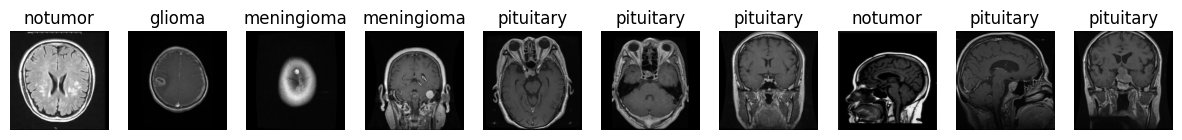

In [ ]:
def visualize_data(images, labels, label_names, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(label_names[labels[idx]])
        plt.axis('off')
    plt.show()

visualize_data(x_train, y_train, labels, num_samples=10)

In [ ]:
x_train = np.array(x_train)[..., np.newaxis] / 255.0
x_test = np.array(x_test)[..., np.newaxis] / 255.0


print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (5738, 200, 200, 1)
Test data shape: (1321, 200, 200, 1)


In [ ]:

# Convert labels to categorical (one-hot encoding)
num_classes = len(labels)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training labels shape: (5738, 4)
Test labels shape: (1321, 4)


In [ ]:
# Split the training data into training and validation sets

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)


Training data shape: (4590, 200, 200, 1)
Validation data shape: (1148, 200, 200, 1)
Test data shape: (1321, 200, 200, 1)


In [ ]:

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

# Compile the model with categorical_crossentropy for one-hot encoded labels
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,667,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,760,452 (33.42 MB)

 Trainable params: 8,760,452 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5090 - loss: 1.1507 - val_accuracy: 0.8040 - val_loss: 0.5250
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8033 - loss: 0.5189 - val_accuracy: 0.8301 - val_loss: 0.4218
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8587 - loss: 0.3752 - val_accuracy: 0.8667 - val_loss: 0.3365
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8959 - loss: 0.2681 - val_accuracy: 0.8885 - val_loss: 0.3050
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9070 - loss: 0.2359 - val_accuracy: 0.9111 - val_loss: 0.2555
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9198 - loss: 0.2131 - val_accuracy: 0.9120 - val_loss: 0.2307
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9474 - loss: 0.1408 - val_accuracy: 0.9059 - val_loss: 0.2577
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9595 - loss: 0.1135 - val

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9214 - loss: 0.3381
Test accuracy: 0.9462528228759766


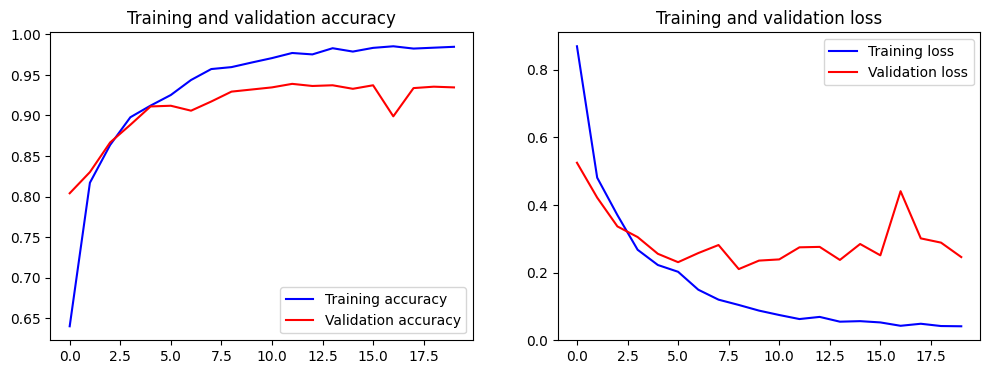

In [ ]:
# Plot training and validation accuracy and loss

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.90      0.88      0.89       316
     notumor       0.96      0.99      0.97       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.95      1321
   macro avg       0.95      0.94      0.94      1321
weighted avg       0.95      0.95      0.95      1321



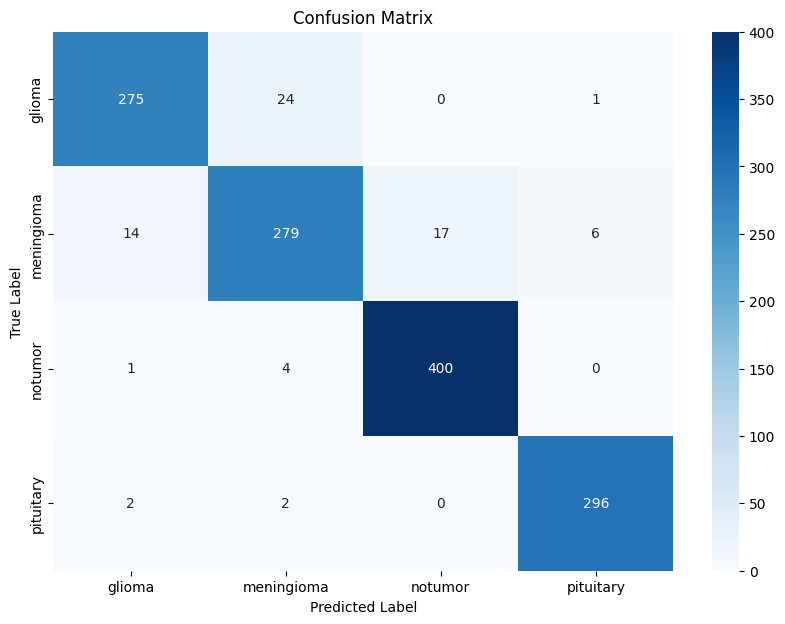

In [ ]:
# Convert one-hot encoded labels to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


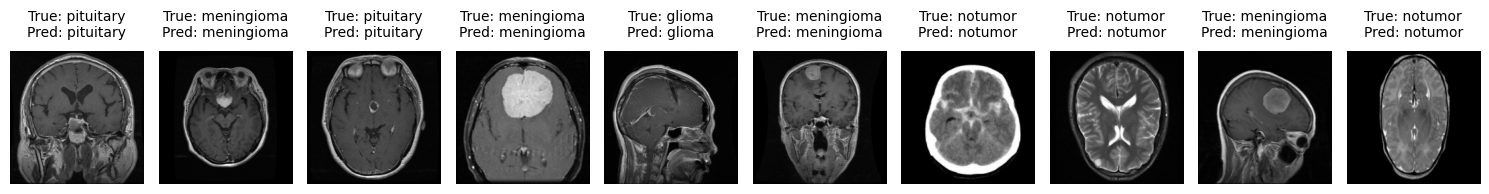

In [ ]:


def visualize_test_predictions(images, labels, label_names, model, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]

        # Convert one-hot encoded labels to integer indices
        true_label = np.argmax(labels[idx])

        # Predict the label
        pred_label = np.argmax(model.predict(img[np.newaxis, ...])[0])

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')

        # Format the title with two lines
        plt.title(f"True: {label_names[true_label]}\nPred: {label_names[pred_label]}", fontsize=10, pad=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize test predictions
visualize_test_predictions(x_test, y_test, labels, model, num_samples=10)




In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Brain-Mri-Classification/cnn_model.h5'
model.save(model_save_path)

print("cnn model saved as my_model.h5")

cnn model saved as my_model.h5
